# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split

models        = []
strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 4

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

Using TensorFlow backend.


# Model setup

In [2]:
def initModels():
    models = []
    
    for i in range(ampNumber):
        models.append(MultiOutputRegressor(KNeighborsRegressor()))
    
    return models
        

# Cross validation function

In [3]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getGainError(predicted[0], expected[0]) 
            lossError += getLossError(predicted[1], expected[1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [4]:
def trainModel(models):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(models[0], features, result[:, 0: 2])
    
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    strategyArray.append("KNN - Amp 1")
    
    prediction = models[0].predict(features)
    for i in range(1, ampNumber):
        gainErrors, lossErrors = crossValidate(models[i], np.hstack((features, prediction)), result[:, i * 2: i * 2 + 2])

        print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
        print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))

        gainArray.append(gainErrors)
        lossArray.append(lossErrors)
        strategyArray.append("KNN - Amp {}".format(i + 1))
        
        prediction = models[i].predict(np.hstack((features, prediction)))
    
    return gainErrors, lossErrors

# Plotting functions

In [5]:
def plotDistribution(models):
    train_results = []
    test_results  = []
    features, result                 = loadDataset()
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 5)
    
    models[0].fit(X_train, y_train[:, 0: 2])
    train_results.append(models[0].predict(X_train))
    test_results.append(models[0].predict(X_test))
    
    for i in range(1, ampNumber):
        models[i].fit(np.hstack((X_train, train_results[i - 1])), y_train[:, i * 2: i * 2 + 2])
        train_results.append(models[i].predict(np.hstack((X_train, train_results[i - 1]))))
        test_results.append(models[i].predict(np.hstack((X_test, test_results[i - 1]))))
    
    fig, axis = plt.subplots(figsize = (10, 5))
    vGain     = np.vectorize(invertGainNorm)
    vLoss     = np.vectorize(invertLossNorm)
    
    axis.scatter(vGain(y_test[:, ampNumber * 2 - 2]), vLoss(y_test[:, ampNumber * 2 - 1]))
    axis.scatter(vGain(test_results[-1][:, 0]), vLoss(test_results[-1][:, 1]), c = "m")
    
    axis.set_title("Test Error - Last Amplifier")
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [6]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = gainArray

    axis.boxplot(data)
    axis.set_title("Train Gain Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = lossArray

    axis.boxplot(data)
    axis.set_title("Train Loss Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [8]:
def plotLinkError():
    fig, axis = plt.subplots(figsize = (10, 5))
    lossData  = np.array(lossArray).flatten()
    gainData  = np.array(gainArray).flatten()
    
    axis.boxplot([lossData, gainData])
    axis.set_title("Link Train Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Error"])
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

# Putting all together

In [9]:
gainArray = []
lossArray = []

In [10]:
models = initModels()
trainModel(models)

[0.69387464 0.50042735 0.27037037 0.50783476 0.71958689] => 0.54 (+/- 0.32)
[0.6968661  0.60035613 0.8011396  0.81830484 1.03981481] => 0.79 (+/- 0.29)

[0.7502849  0.59408832 0.35925926 0.50904558 0.62635328] => 0.57 (+/- 0.26)
[0.44722222 0.78205128 0.57464387 1.25306268 1.26659544] => 0.86 (+/- 0.68)

[0.2210114  0.42008547 0.31303419 0.18397436 0.26495726] => 0.28 (+/- 0.16)
[0.42649573 0.30035613 0.42492877 0.67264957 0.75947293] => 0.52 (+/- 0.34)

[0.70149573 0.43753561 0.76089744 0.5980057  0.65562678] => 0.63 (+/- 0.22)
[0.48447293 0.5264245  0.56737892 0.45655271 0.26652422] => 0.46 (+/- 0.21)



(array([0.70149573, 0.43753561, 0.76089744, 0.5980057 , 0.65562678]),
 array([0.48447293, 0.5264245 , 0.56737892, 0.45655271, 0.26652422]))

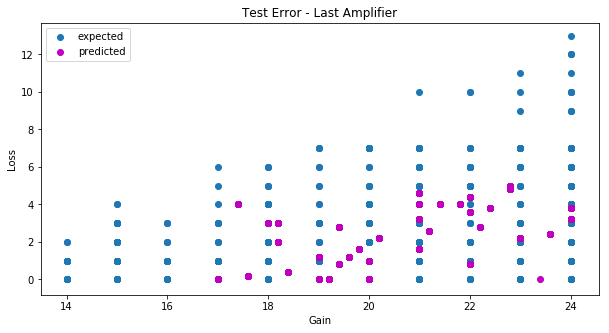

In [11]:
plotDistribution(models)

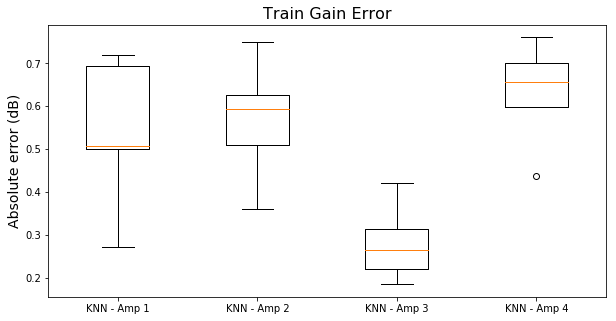

In [12]:
plotGainError()

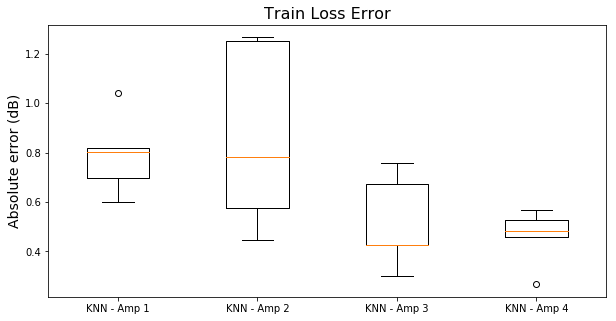

In [13]:
plotLossError()

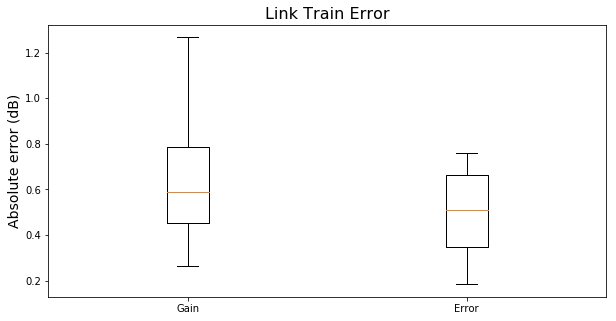

In [14]:
plotLinkError()